In [57]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('dark')

import os
import datetime

import cv2

In [58]:
def rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def disp(img, title='', s=8, vmin=None, vmax=None):
    plt.figure(figsize=(s,s))
    plt.axis('off')
    if vmin is not None and vmax is not None:
        plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()

def uint8ify(img):
    img -= img.min()
    img /= img.max()
    img *= 255
    return np.uint8(img)

def overlay(a,b):
    # a and b should be float images and between 0-1

    mask = a >= 0.5 # generate boolean mask of everywhere a > 0.5 
    ab = np.zeros_like(a) # generate an output container for the blended image 

    # now do the blending 
    ab[~mask] = (2*a*b)[~mask] # 2ab everywhere a<0.5
    ab[mask] = (1-2*(1-a)*(1-b))[mask] # else this
    
    return ab

def before_after(img_a, img_b, name='', vmin=None, vmax=None, effect_name='Processed'):
    fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(10,4))
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].set_title(f'{name} Original')
    axs[1].set_title(f'{name} {effect_name}')
    if vmin is not None and vmax is not None:
        axs[0].imshow(img_a, cmap='gray', vmin=vmin, vmax=vmax)
        axs[1].imshow(img_b, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        axs[0].imshow(img_a, cmap='gray')
        axs[1].imshow(img_b, cmap='gray')
    plt.show()

In [59]:
# import images from dataset/proposals/bg
def import_images(path):
    images = []
    for filename in os.listdir(path):
        img = gray(rgb(cv2.imread(os.path.join(path,filename))))
        images.append(img)
    return images

## Load Dataset

In [60]:
folders = [
    '../dataset/proposals/bg',
    '../dataset/proposals/c',
    '../dataset/proposals/d',
    '../dataset/proposals/t',
    '../dataset/proposals/w']

class_names = ['bg', 'c', 'd', 't', 'w']

bg_images = import_images(folders[0])
c_images = import_images(folders[1])
d_images = import_images(folders[2])
t_images = import_images(folders[3])
w_images = import_images(folders[4])

print(f"{len(bg_images)=}\n{len(c_images)=}\n{len(d_images)=}\n{len(t_images)=}\n{len(w_images)=}")


len(bg_images)=2953
len(c_images)=1641
len(d_images)=715
len(t_images)=681
len(w_images)=204


## Feature Extraction


In [61]:
#import local binary patterns from skimage
from skimage.feature import local_binary_pattern

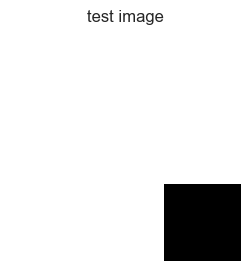

array([[0. , 0.4, 0. ],
       [0.4, 0.8, 0. ],
       [0. , 0. , 1. ]])

In [62]:
test_img = np.ones((3,3))
test_img[1,1] = 1
test_img[2,2] = 0
disp(test_img, 'test image', s=3)

lbp = local_binary_pattern(test_img, 8, 1, method='uniform')
lbp -= lbp.min()
lbp /= lbp.max()
lbp

In [63]:
# Test Feature Extraction that works surprisingly well
def extract_features(img):
    return np.array([np.mean(img)]) 
    return np.array([np.mean(img), np.std(img), np.median(img), np.min(img), np.max(img)]) # Very good!

# Extract features LBP
def extract_features(img):
    lbp = local_binary_pattern(img, 16, 3, method='uniform').astype('float32')
    lbp -= lbp.min()
    lbp /= lbp.max()
    hist, _ = np.histogram(lbp.ravel(), bins=16, range=(0, 1))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    # lbp = local_binary_pattern(img, 8, 1, method='uniform')
    # (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 9), range=(0, 8))
    # hist = hist.astype("float")
    # hist /= (hist.sum() + 1e-7)
    return hist

In [64]:
# for i in range(10):
#     hist = extract_features(c_images[i])
#     plt.scatter(np.arange(0, 16), hist, color='b', alpha=1, s=4)
#     # plt.bar(np.arange(0, 16), hist, color='r', width=0.8, alpha=0.2)
# plt.show()


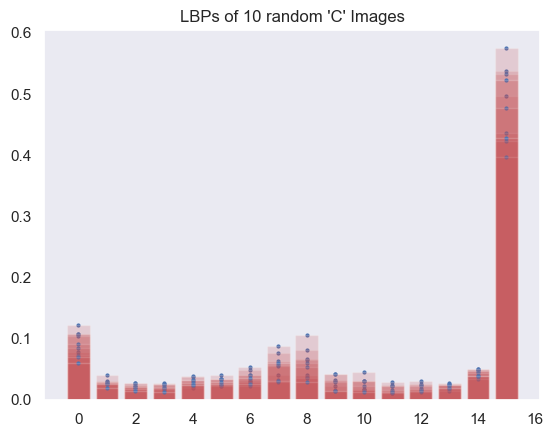

In [65]:
plt.figure()
plt.title("LBPs of 10 random 'C' Images")
random_idx = np.random.randint(0, len(c_images), 10)
for i in random_idx:
    hist = extract_features(c_images[i])
    plt.scatter(np.arange(0, 16), hist, color='b', alpha=1, s=4)
    plt.bar(np.arange(0, 16), hist, color='r', width=0.8, alpha=0.2)
plt.show()


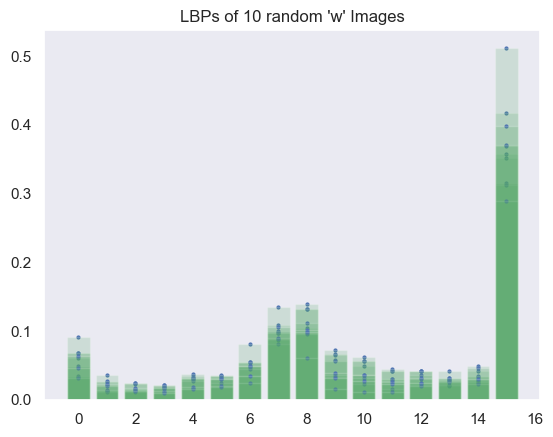

In [66]:
plt.figure()
plt.title("LBPs of 10 random 'w' Images")
random_idx = np.random.randint(0, len(w_images), 10)
for i in random_idx:
    hist = extract_features(w_images[i])
    plt.scatter(np.arange(0, 16), hist, color='b', alpha=1, s=4)
    plt.bar(np.arange(0, 16), hist, color='g', width=0.8, alpha=0.2)
plt.show()


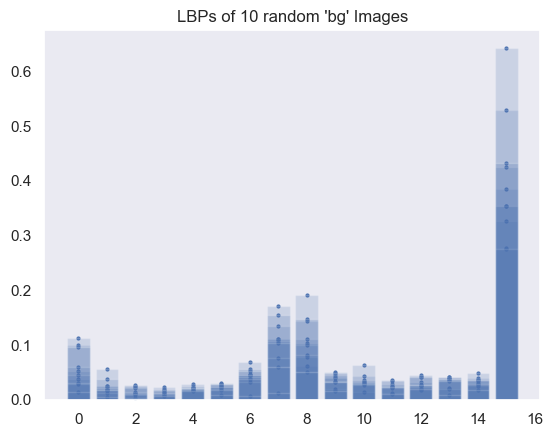

In [67]:
plt.figure()
plt.title("LBPs of 10 random 'bg' Images")
random_idx = np.random.randint(0, len(bg_images), 10)
for i in random_idx:
    hist = extract_features(bg_images[i])
    plt.scatter(np.arange(0, 16), hist, color='b', alpha=1, s=4)
    plt.bar(np.arange(0, 16), hist, color='b', width=0.8, alpha=0.2)
plt.show()


In [68]:
# for i in range(10):
#     hist = extract_features(c_images[i])
#     plt.bar(np.arange(0, 16), hist, color='r', width=0.8, alpha=0.2)
# plt.show()


### Create X, y 

In [69]:
# X = []
# y = []

# for img in bg_images:
#     # X.append(extract_features(img))
#     y.append(0)
# print("bg done")

# for img in c_images:
#     # X.append(extract_features(img))
#     y.append(1)
# print("c done")

# for img in d_images:
#     # X.append(extract_features(img))
#     y.append(2)
# print("d done")

# for img in t_images:
#     # X.append(extract_features(img))
#     y.append(3)
# print("t done")

# for img in w_images:
#     # X.append(extract_features(img))
#     y.append(4)
# print("w done")

# # X = np.array(X)
# y = np.array(y)

# print(f"{X.shape=}\n{y.shape=}")

124 secs to run on a single core

12 secs to run on 16 cores

In [70]:
# [10*[0]][0]

In [71]:
# from joblib import Parallel, delayed

# def do(i):
#     return [i for j in range(i)]


In [72]:
# do1 = delayed(do)(1)
# do2 = delayed(do)(2)
# do3 = delayed(do)(3)
# do4 = delayed(do)(4)

# res = Parallel(n_jobs=4)([do1, do2, do3, do4])

# res

In [73]:
# [do(i) for i in range(4)]

In [74]:
# [delayed(do)(i) for i in range(4)]

In [75]:
# res = Parallel(n_jobs=4)([delayed(do)(i) for i in range(4)])

# res

In [76]:
from joblib import Parallel, delayed

# run in parallel
def extract_features_parallel(img):
    return extract_features(img)

X = []
y = [len(bg_images)*[0]][0] + [len(c_images)*[1]][0] + [len(d_images)*[2]][0] + [len(t_images)*[3]][0] + [len(w_images)*[4]][0] # 0,0,0,0,0, ... , 1,1,1,1,1, ... , 2,2,2,2,2, ... , 3,3,3,3,3, ... , 4,4,4,4,4, ...


all_images = bg_images + c_images + d_images + t_images + w_images
X = Parallel(n_jobs=-1)([delayed(extract_features_parallel)(img) for img in all_images])

X = np.array(X)
y = np.array(y)

print(f"{X.shape=}\n{y.shape=}")

X.shape=(6194, 16)
y.shape=(6194,)


In [77]:
import sys
print(f"size of bg_images: {sys.getsizeof(bg_images)/1024/1024:.3f} MB")
print(f"size of c_images: {sys.getsizeof(c_images)/1024/1024:.3f} MB")
print(f"size of d_images: {sys.getsizeof(d_images)/1024/1024:.3f} MB")
print(f"size of t_images: {sys.getsizeof(t_images)/1024/1024:.3f} MB")
print(f"size of w_images: {sys.getsizeof(w_images)/1024/1024:.3f} MB")
print(f"size of all_images: {sys.getsizeof(all_images)/1024/1024:.3f} MB")

size of bg_images: 0.025 MB
size of c_images: 0.014 MB
size of d_images: 0.006 MB
size of t_images: 0.006 MB
size of w_images: 0.002 MB
size of all_images: 0.047 MB


In [78]:
del bg_images, c_images, d_images, t_images, w_images

### Train Test Split

In [79]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)
print(f"{X_train.shape=}\n{X_test.shape=}\n{y_train.shape=}\n{y_test.shape=}")

X_train.shape=(4335, 16)
X_test.shape=(1859, 16)
y_train.shape=(4335,)
y_test.shape=(1859,)


## Classification

### Feature Scaling

In [ ]:
X_train[0]

array([93.33680504])

In [80]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train[0]

array([-0.43059114])

### Training


In [81]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

model = KNeighborsClassifier(n_neighbors=1)
# model = SVC(kernel='linear', C=1.0, gamma='auto')

model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

## Plot the data using TSNE

c:\Users\gholamreza\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\gholamreza\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


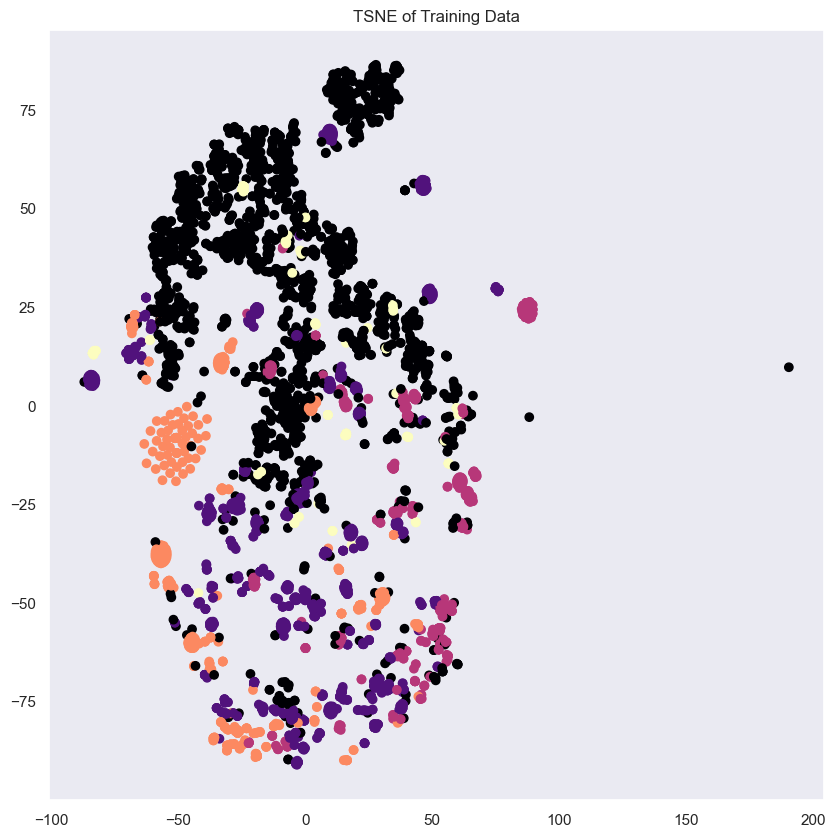

In [85]:
# # plot the data using tsne
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, random_state=69, perplexity=30, n_iter=1000)
# X_embedded = tsne.fit_transform(X_train)

# plt.figure(figsize=(10,10))
# plt.title('TSNE of Training Data')
# plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_train, cmap='magma')
# plt.show()


### Evaluation


In [82]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
# y_pred = np.zeros_like(y_pred) + 0
# y_pred = np.random.randint(0, 5, size=y_pred.shape)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       903
           1       0.95      1.00      0.97       488
           2       0.92      0.97      0.94       200
           3       0.94      0.99      0.97       192
           4       0.96      0.86      0.90        76

    accuracy                           0.96      1859
   macro avg       0.95      0.95      0.95      1859
weighted avg       0.97      0.96      0.96      1859



c:\Users\gholamreza\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


<AxesSubplot:title={'center':'Confusion Matrix'}>

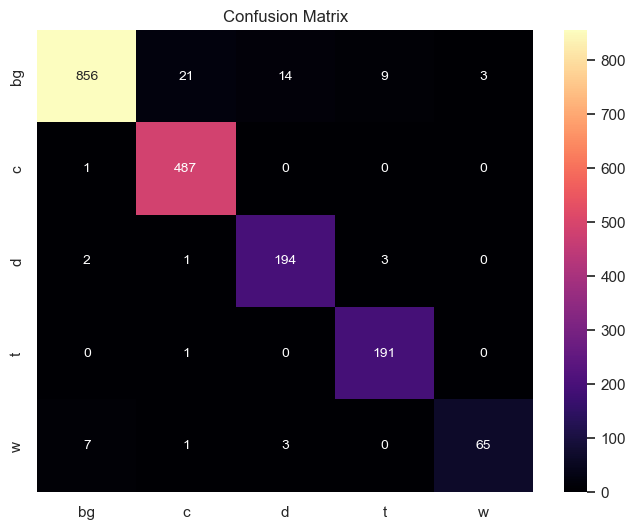

In [83]:
plt.figure(figsize=(8,6))
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='magma', cbar=True, xticklabels=class_names, yticklabels=class_names, annot_kws={'size': 10})

## Regression